In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.cm
import os
import pandas as pd
import random
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
import dash
import dash_html_components as html
import dash_core_components as dcc

sys.path.append(os.path.abspath("../activeweasul"))
from synthetic_data import SyntheticDataGenerator
from logisticregression import LogisticRegression
from discriminative_model import DiscriminativeModel
from label_model import LabelModel
from active_weasul import ActiveWeaSuLPipeline, set_seed, CustomTensorDataset
from experiments import process_metric_dict, plot_metrics, active_weasul_experiment, process_exp_dict, active_learning_experiment

In [2]:
N = 10000
centroids = np.array([[0.1, 1.3], [-0.8, -0.5]])
p_z = 0.5

set_seed(932)
data = SyntheticDataGenerator(N, p_z, centroids)
df = data.sample_dataset().create_df()

df.loc[:, "wl1"] = (df.x2<0.4)*1
df.loc[:, "wl2"] = (df.x1<-0.3)*1
df.loc[:, "wl3"] = (df.x1<-1)*1

label_matrix = df[["wl1", "wl2", "wl3"]].values
y_train = df.y.values

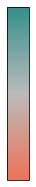

In [3]:
cmap = clr.LinearSegmentedColormap.from_list('', ['#ec7357',"#BBBBBB",'#368f8b'], N=200)
matplotlib.cm.register_cmap("mycolormap", cmap)

norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="mycolormap", norm=norm)
sm.set_array([])

fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_axes([0.1, 0.1, 0.03, 0.8])
cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='vertical',
                                ticks=[])
plt.savefig("../plots/colorbar.png")

In [4]:
cmap = clr.LinearSegmentedColormap.from_list('', ['#368f8b',"#BBBBBB",'#ec7357'], N=200)
matplotlib.cm.register_cmap("mycolormap", cmap)

norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="mycolormap", norm=norm)
sm.set_array([])

In [5]:
bp1 = centroids.sum(axis=0)/2
diff = centroids[1,:]-centroids[0,:]
slope = diff[1]/diff[0]
perp_slope = -1/slope
b = bp1[1] - perp_slope*bp1[0]
coef = [b, perp_slope, -1]
x_dec = np.linspace(centroids[0,0]-4, centroids[1,0]+4, 1000)
y_dec = (- coef[0] - coef[1]*x_dec)/coef[2]

In [6]:
sns.set(style="white",rc={'figure.figsize':(5,5)})
point_size=25

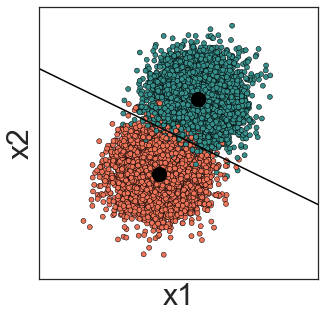

In [7]:

plt.scatter(x=df.x1, y=df.x2, c=df.y, s=point_size, edgecolor="black", linewidth=0.5, cmap=cmap)
plt.plot(x_dec, y_dec, color="black")
plt.scatter(0.1, 1.3, s=200, color="black")
plt.scatter(-0.8, -0.5, s=200, color="black")

plt.xlim(-3.6,2.9)
plt.ylim(-3,3.5)
plt.xlabel("x1", fontsize=30)
plt.ylabel("x2", fontsize=30)
plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/truesyntdata.png")

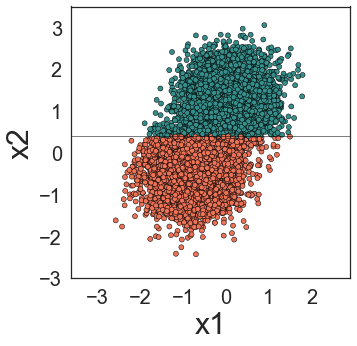

In [8]:
plt.scatter(x=df.x1, y=df.x2, c=df.wl1, s=point_size, edgecolor="black", linewidth=0.5, cmap=cmap)
plt.plot([-5, 5],[0.4, 0.4], linewidth=.5, color="black")
plt.xlim(-3.6,2.9)
plt.ylim(-3,3.5)
plt.xlabel("x1", fontsize=30)
plt.ylabel("x2", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("../plots/truesyntdata_wl1.png")

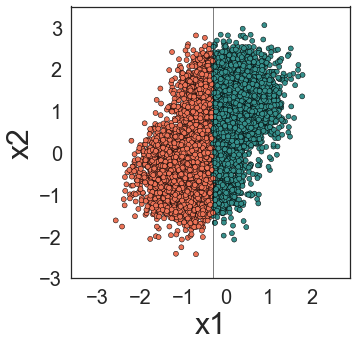

In [9]:
plt.scatter(x=df.x1, y=df.x2, c=df.wl2, s=point_size, edgecolor="black", linewidth=0.5, cmap=cmap)
plt.plot([-0.3, -0.3], [-5, 5], linewidth=.5, color="black")
plt.xlim(-3.6,2.9)
plt.ylim(-3,3.5)
plt.xlabel("x1", fontsize=30)
plt.ylabel("x2", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("../plots/truesyntdata_wl2.png")

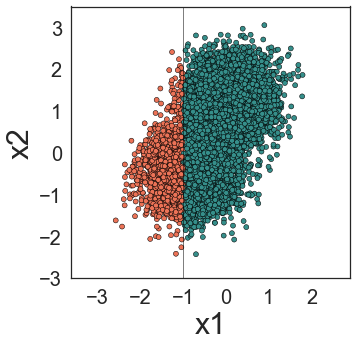

In [10]:
plt.scatter(x=df.x1, y=df.x2, c=df.wl3, s=point_size, edgecolor="black", linewidth=0.5, cmap=cmap)
plt.plot([-1, -1], [-5, 5], linewidth=.5, color="black")
plt.xlim(-3.6,2.9)
plt.ylim(-3,3.5)
plt.xlabel("x1", fontsize=30)
plt.ylabel("x2", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("../plots/truesyntdata_wl3.png")

## Small example dataset

In [11]:
N = 200
centroids = np.array([[0.1, 1.3], [-0.8, -0.5]])
p_z = 0.5

set_seed(641)
data = SyntheticDataGenerator(N, p_z, centroids)
df_example = data.sample_dataset().create_df()

df_example.loc[:, "wl1"] = (df_example.x2<0.4)*1
df_example.loc[:, "wl2"] = (df_example.x1<-0.3)*1
df_example.loc[:, "wl3"] = (df_example.x1<-1)*1

label_matrix_example = df_example[["wl1", "wl2", "wl3"]].values
y_example = df_example.y.values

In [12]:
colors = ["#368f8b", "#ec7357"]

sns.set(style="white", palette=sns.color_palette(colors), rc={'figure.figsize':(5,5)})

sns.set_context("paper")

point_size=200
legend_size=15
font_size=15
line_width=2

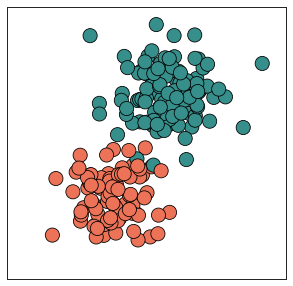

In [14]:
plt.figure(figsize=(5,5))
plt.scatter(x=df_example.x1, y=df_example.x2, c=df_example.y, s=point_size, edgecolor="black", cmap=cmap)
plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)
# plt.xlabel("x1", fontsize=font_size)
# plt.ylabel("x2", fontsize=font_size)
plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/truelabels.png")

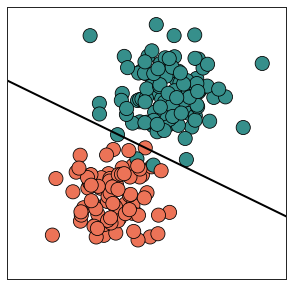

In [15]:
plt.figure(figsize=(5,5))
plt.scatter(x=df_example.x1, y=df_example.x2, c=df_example.y, s=point_size, edgecolor="black", cmap=cmap)
plt.plot(x_dec, y_dec, color="black", linewidth=line_width)
plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)
# plt.xlabel("x1", fontsize=font_size)
# plt.ylabel("x2", fontsize=font_size)
plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/truelabels-2.png")

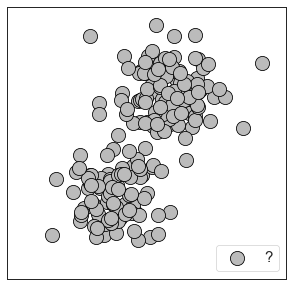

In [14]:
plt.scatter(x=df_example.x1, y=df_example.x2, c="#BBBBBB", s=point_size, edgecolor="black", cmap=cmap)
plt.legend(labels="?", loc="lower right", prop={'size': legend_size})
plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)
# plt.xlabel("x1", fontsize=font_size)
# plt.ylabel("x2", fontsize=font_size)
plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/missinglabels.png")

In [15]:
set_seed(285)

_, unique_idx, unique_inverse = np.unique(label_matrix_example, axis=0, return_index=True, return_inverse=True)

sampled_idx = random.sample(list(df_example[unique_inverse == 3].index), 5)

df_example["u"] = 0.5

df_example.loc[sampled_idx, "u"] = df_example.loc[sampled_idx, "y"]

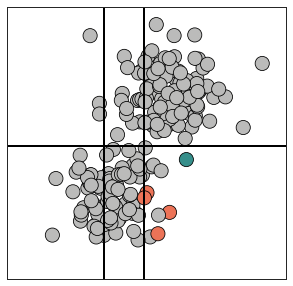

In [16]:
plt.scatter(x=df_example.x1, y=df_example.x2, c=df_example.u, s=point_size, edgecolor="black", cmap=cmap)
plt.clim(0,1)
plt.plot([-5, 5],[0.4, 0.4], linewidth=line_width, color="black")
plt.plot([-0.3, -0.3], [-5, 5], linewidth=line_width, color="black")
plt.plot([-1, -1], [-5, 5], linewidth=line_width, color="black")
plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)
plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/example_samples.png")

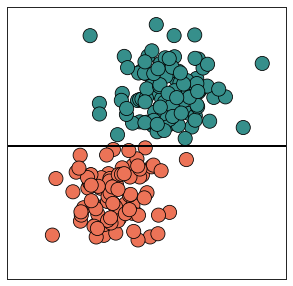

In [17]:
plt.scatter(x=df_example.x1, y=df_example.x2, c=df_example.wl1, s=point_size, edgecolor="black", cmap=cmap)

plt.plot([-5, 5],[0.4, 0.4], linewidth=line_width, color="black")

plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)
# plt.xlabel("x1", fontsize=font_size)
# plt.ylabel("x2", fontsize=font_size)

plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/wl1.png")

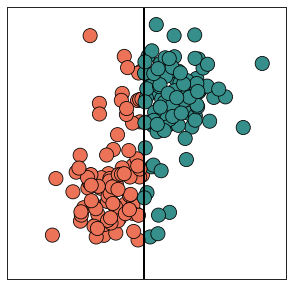

In [18]:
plt.scatter(x=df_example.x1, y=df_example.x2, c=df_example.wl2, s=point_size, edgecolor="black", cmap=cmap)

plt.plot([-0.3, -0.3], [-5, 5], linewidth=line_width, color="black")

plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)
# plt.xlabel("x1", fontsize=font_size)
# plt.ylabel("x2", fontsize=font_size)

plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/wl2.png")

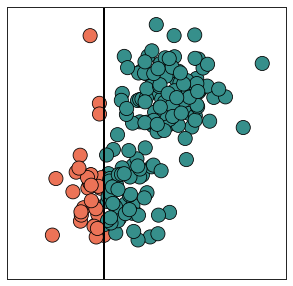

In [19]:
plt.scatter(x=df_example.x1, y=df_example.x2, c=df_example.wl3, s=point_size, edgecolor="black", cmap=cmap)

plt.plot([-1, -1], [-5, 5], linewidth=line_width, color="black")
plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)
# plt.xlabel("x1", fontsize=font_size)
# plt.ylabel("x2", fontsize=font_size)
plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/wl3.png")

In [20]:
class_balance = np.array([1 - p_z, p_z])
cliques=[[0],[1,2]]

L = df[["wl1", "wl2", "wl3"]].values

lm = LabelModel(n_epochs=200,
                lr=1e-1)
    
Y_probs = lm.fit(label_matrix=L, cliques=cliques, class_balance=class_balance).predict()


Y_probs_example = lm.predict(label_matrix_example, lm.mu, df_example.y.mean())

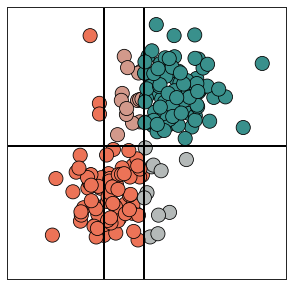

In [21]:
plt.scatter(x=df_example.x1, y=df_example.x2, c=Y_probs_example[:,1].detach().numpy(), s=point_size, edgecolor="black", cmap=cmap)
plt.clim(0,1)

plt.plot([-5, 5],[0.4, 0.4], linewidth=line_width, color="black")
plt.plot([-0.3, -0.3], [-5, 5], linewidth=line_width, color="black")
plt.plot([-1, -1], [-5, 5], linewidth=line_width, color="black")

plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)
# plt.xlabel("x1", fontsize=font_size)
# plt.ylabel("x2", fontsize=font_size)
plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/problabels_ba.png")

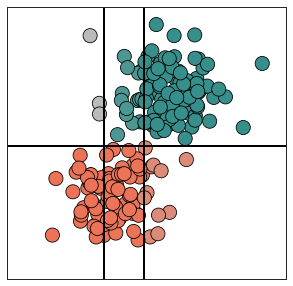

In [22]:
plt.scatter(x=df_example.x1, y=df_example.x2, c=np.unique(lm.predict_true(y_train)[:,1])[unique_inverse], s=point_size, edgecolor="black", cmap=cmap)
plt.clim(0,1)

plt.plot([-5, 5],[0.4, 0.4], linewidth=line_width, color="black")
plt.plot([-0.3, -0.3], [-5, 5], linewidth=line_width, color="black")
plt.plot([-1, -1], [-5, 5], linewidth=line_width, color="black")

plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)

plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/optimal_labels.png")

In [25]:
set_seed(76)

train_dataset = CustomTensorDataset(X=torch.Tensor(df[["x1", "x2"]].values), Y=Y_probs.detach())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

test_dataset = CustomTensorDataset(X=torch.Tensor(df_example[["x1", "x2"]].values), Y=Y_probs_example.detach())
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

dm = LogisticRegression(input_dim=2, output_dim=2, lr=1e-1, n_epochs=3, soft_labels=True)

train_preds = dm.fit(train_loader).predict()
test_preds = dm.predict(test_dataloader)

In [26]:
decbound_points = df.iloc[np.argsort(np.abs(train_preds[:,1]-0.5))[:2]][["x1", "x2"]].values
a = (decbound_points[1,1] - decbound_points[0,1])/(decbound_points[1,0] - decbound_points[0,0])
b = decbound_points[0,1] - decbound_points[0,0]*a
y1 = a*-2.5 + b
y2 = a*1.7 + b

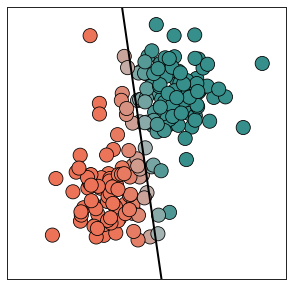

In [27]:
plt.scatter(x=df_example.x1, y=df_example.x2, c=test_preds[:,1].detach().numpy(), s=point_size, edgecolor="black", cmap=cmap)
plt.clim(0,1)

plt.plot([-2.5, 1.7],[y1, y2], linewidth=line_width, color="black")

plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)

plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/finallabels_ba.png")

In [28]:
it = 30
query_strategy = "maxkl"

final_model_kwargs = dict(input_dim=2,
                          output_dim=2,
                          lr=1e-1,
                          n_epochs=100)

seed = 52

al = ActiveWeaSuLPipeline(it=it,
                          final_model=LogisticRegression(**final_model_kwargs),
                          n_epochs=200,
                          query_strategy=query_strategy,
                          discr_model_frequency=30,
                          penalty_strength=1,
                          batch_size=256,
                          randomness=0,
                          seed=seed,
                          starting_seed=243)

Y_probs_al = al.run_active_weasul(label_matrix=label_matrix,
                                  y_train=y_train,
                                  cliques=cliques,
                                  class_balance=class_balance,
                                  train_dataset=CustomTensorDataset(X=torch.Tensor(df.loc[:,["x1", "x2"]].values), Y=Y_probs.detach()),
                                  test_dataset=CustomTensorDataset(X=torch.Tensor(df_example.loc[:,["x1", "x2"]].values), Y=y_example),
                                  label_matrix_test=label_matrix_example,
                                  y_test=y_example,
                                  )

In [29]:
decbound_points = df.iloc[np.argsort(np.abs(al.probs["Discriminative_train"][30]-0.5))[:2]][["x1", "x2"]].values
a = (decbound_points[1,1] - decbound_points[0,1])/(decbound_points[1,0] - decbound_points[0,0])
b = decbound_points[0,1] - decbound_points[0,0]*a
y1 = a*-2.7 + b
y2 = a*2.2 + b

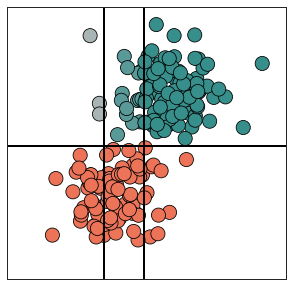

In [30]:
plt.scatter(x=df_example.x1, y=df_example.x2, c=al.probs["Generative_test"][30], s=point_size, edgecolor="black", cmap=cmap)
plt.clim(0,1)
plt.plot([-5, 5],[0.4, 0.4], linewidth=line_width, color="black")
plt.plot([-0.3, -0.3], [-5, 5], linewidth=line_width, color="black")
plt.plot([-1, -1], [-5, 5], linewidth=line_width, color="black")

plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)
# plt.xlabel("x1", fontsize=font_size)
# plt.ylabel("x2", fontsize=font_size)
plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/problabels_aa.png")

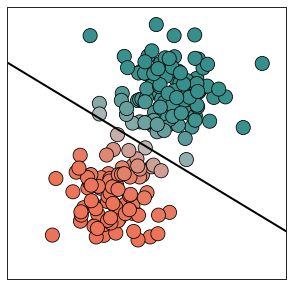

In [31]:
plt.scatter(x=df_example.x1, y=df_example.x2, c=al.probs["Discriminative_test"][30], s=point_size, edgecolor="black", cmap=cmap)
plt.clim(0,1)
plt.plot([-2.7,2.2],[y1, y2], linewidth=line_width, color="black")

plt.xlim(-2.7,2.2)
plt.ylim(-2,2.9)
# plt.xlabel("x1", fontsize=font_size)
# plt.ylabel("x2", fontsize=font_size)
plt.xticks([], [])
plt.yticks([], [])

plt.savefig("../plots/finallabels_aa.png")